# MCMCシミュレーションコードのテスト

MCMCシミュレーションのコードを改良したため、ちゃんと動作しているかテスト。

## import

In [21]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import random

import mcmc_function as mcmc
import ising_model as ising
from ising_model import Ising_model
import QAOA_function as qaoa
from QAOA_function import QAOA_ansatz
import made

seed = 1454
rng = np.random.default_rng(seed)

## コードの改良

最後にacceptされた配置の情報を保持するように改良。

In [3]:
def ssf_update_new(init_spin, instance, beta, n_iter, rng=None):
	if rng == None:
		rng = np.random.default_rng()
    
	n_spin = init_spin.shape[0]
	state_history = np.zeros((n_iter+1, n_spin))
	state_history[0] = init_spin
	acceptance_history = np.zeros(n_iter)

	accept_state = init_spin

	for i in range(n_iter):
		# make a porposal
		flip_index = rng.integers(0, n_spin)
		proposal_state = mcmc.single_spin_flip(accept_state, flip_index)

		# accept or reject the proposal
		next_state, acceptance, flag = mcmc.boltzmann_metropolis(accept_state, proposal_state, instance, beta, rng)

		# update the accept_state
		state_history[i+1] = next_state
		acceptance_history[i] = acceptance
		if flag:
			accept_state = next_state
	
	return state_history, acceptance_history

## テスト

乱数rngを初期化して発生する遷移が同等の状態でテストする。

In [6]:
n_spin = 5
instance = Ising_model(n_spin, rng, type='SK')
beta = 1.0
n_iter = 100

### 旧version

In [9]:
rng = np.random.default_rng(seed)
init_state = ising.number_to_spin(rng.integers(0, 2**n_spin), n_spin)

state_history_1 = np.zeros((n_iter+1, n_spin))
state_history_1[0] = init_state

for i in range(n_iter):
	state_history_1[i+1] = mcmc.ssf_update(state_history_1[i], instance, beta, rng)[0]

### 新version

In [10]:
rng = np.random.default_rng(seed)
init_state = ising.number_to_spin(rng.integers(0, 2**n_spin), n_spin)

state_history_2 = ssf_update_new(init_state, instance, beta, n_iter, rng)[0]

### 確認

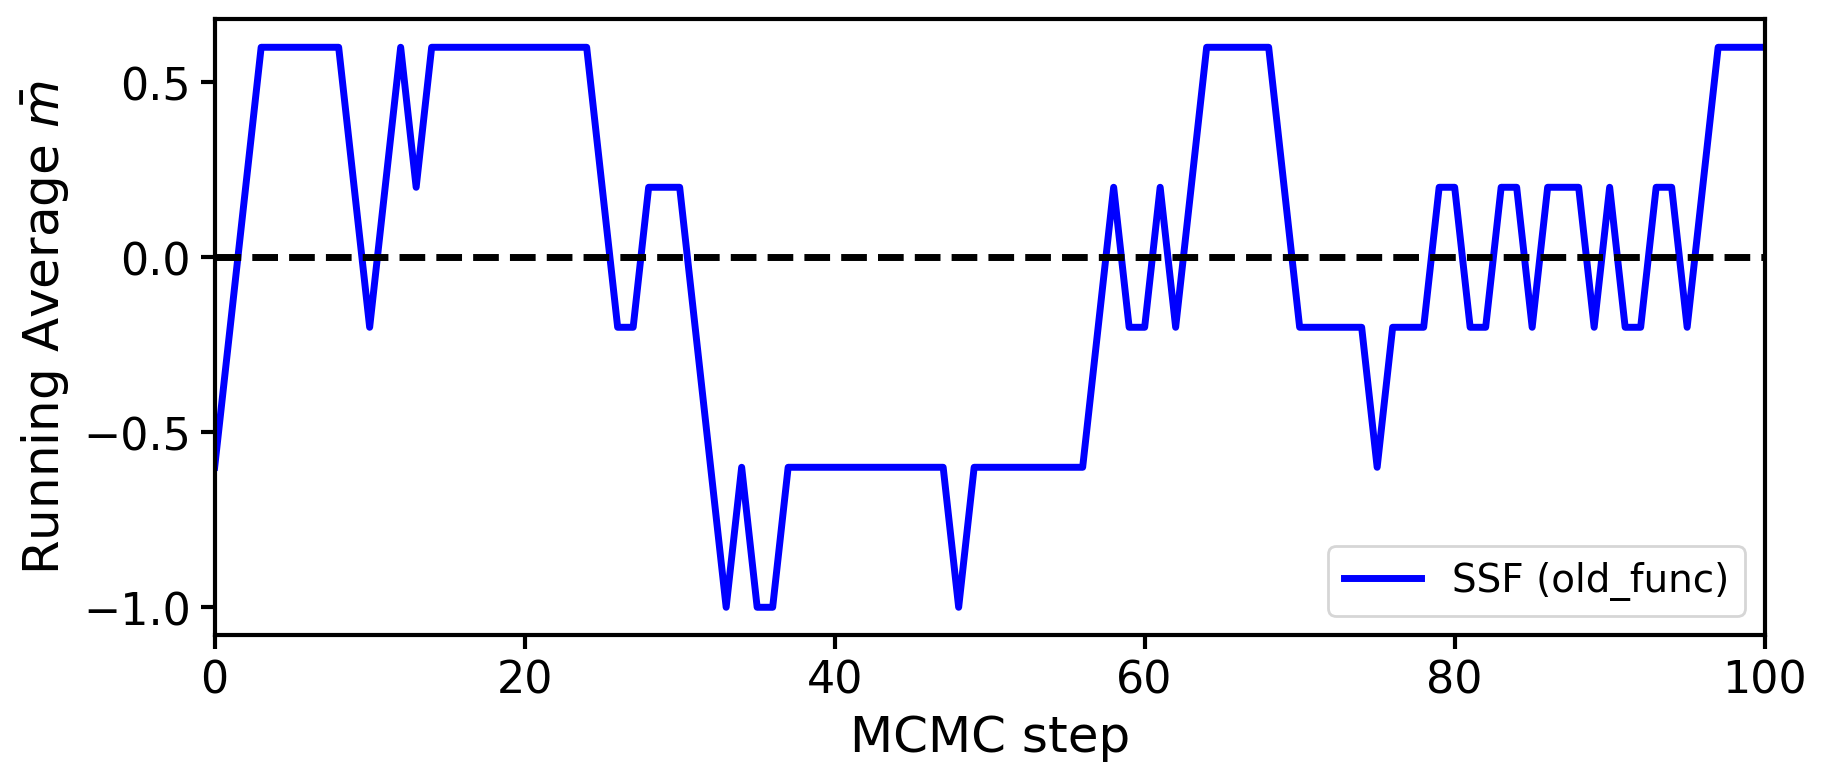

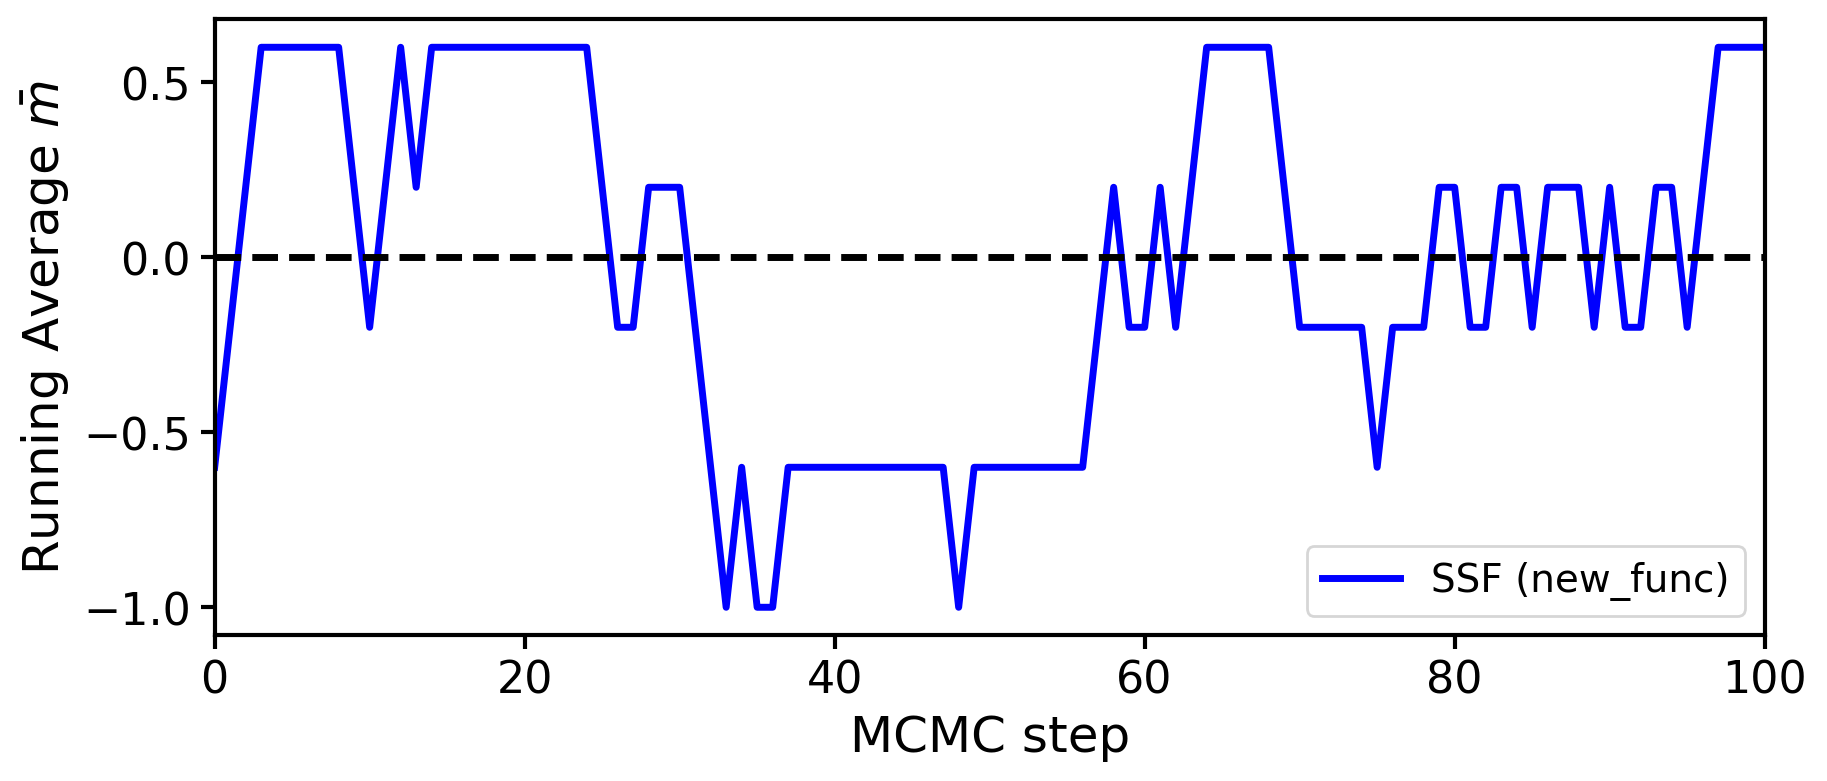

In [13]:
ssf_mag_1 = np.average(state_history_1, axis=1)
ssf_mag_2 = np.average(state_history_2, axis=1)
boltzmann_dist = ising.spin_boltzmann_distribution(instance, beta)
true_val = ising.boltzmann_average_magnetization(n_spin, boltzmann_dist)

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5

fig1_1, ax1_1 = plt.subplots(figsize=(10,4), dpi=200)

ax1_1.spines["top"].set_linewidth(spines)
ax1_1.spines["left"].set_linewidth(spines)
ax1_1.spines["bottom"].set_linewidth(spines)
ax1_1.spines["right"].set_linewidth(spines)

ax1_1.plot(np.arange(n_iter+1), ssf_mag_1, color='blue', linewidth=linewidth, label='SSF (old_func)')
ax1_1.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax1_1.set_xlim(0, n_iter)
#ax1_1.set_ylim(-0.3,0.3)
ax1_1.set_xlabel('MCMC step', fontsize=18)
ax1_1.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax1_1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax1_1.tick_params(axis="x", which='major', width=1.5)
ax1_1.legend(fontsize=14, loc='lower right', frameon=True)

fig1_2, ax1_2 = plt.subplots(figsize=(10,4), dpi=200)

ax1_2.spines["top"].set_linewidth(spines)
ax1_2.spines["left"].set_linewidth(spines)
ax1_2.spines["bottom"].set_linewidth(spines)
ax1_2.spines["right"].set_linewidth(spines)

ax1_2.plot(np.arange(n_iter+1), ssf_mag_2, color='blue', linewidth=linewidth, label='SSF (new_func)')
ax1_2.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax1_2.set_xlim(0, n_iter)
#ax121.set_ylim(-0.3,0.3)
ax1_2.set_xlabel('MCMC step', fontsize=18)
ax1_2.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax1_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax1_2.tick_params(axis="x", which='major', width=1.5)
ax1_2.legend(fontsize=14, loc='lower right', frameon=True)

OK!!

## MADEでのテスト

### 関数定義

In [14]:
def made_update(init_spin, init_log_prob, proposal_history, log_prob_history, instance, beta, n_iter, rng=None):
	if rng == None:
		rng = np.random.default_rng()
    
	n_spin = init_spin.shape[0]
	state_history = np.zeros((n_iter+1, n_spin))
	state_history[0] = init_spin
	acceptance_history = np.zeros(n_iter)

	current_state = init_spin
	current_log_prob = init_log_prob

	for i in range(n_iter):
		# accept or reject the proposal
		next_state, acceptance, flag = mcmc.boltzmann_metropolis_hastings(current_state, proposal_history[i], log_prob_history[i], current_log_prob, instance, beta, rng)

		# update the current_state
		state_history[i+1] = next_state
		acceptance_history[i] = acceptance
		if flag:
			current_state = proposal_history[i]
			current_log_prob = log_prob_history[i]
	
	return state_history, acceptance_history

### テスト

In [35]:
# define instance
n_spin = 10
instance = Ising_model(n_spin, rng, type='SK')
beta = 5.0
n_iter = 1000
n_layers = 5
qaoa_init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
qaoa_method = "BFGS"
qaoa_options = {"disp": False, "maxiter": 200, "gtol": 1e-6}
n_train = 8000
n_test = int(n_train * 0.25)
hidden_size = int(2 * n_spin)
hidden_layers = 2
batchsize = 8
lr = 0.005
n_epochs = 30

In [36]:
random.seed(seed)
generator = torch.Generator().manual_seed(seed)

# optimize QAOA ansatz
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

def qaoa_cost(para):
	return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

qaoa_opt = scipy.optimize.minimize(qaoa_cost, qaoa_init_para, method=qaoa_method, options=qaoa_options)

# sampling from QAOA distribution
qaoa_opt_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_opt.x, n_train+n_test) # optimize parameter
qaoa_opt_data_nd = np.array([qaoa.number_to_binary(qaoa_opt_data_idx[i], n_spin) for i in range(len(qaoa_opt_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！
qaoa_opt_data = torch.from_numpy(qaoa_opt_data_nd).to(dtype=torch.float32)
qaoa_opt_traindata, qaoa_opt_testdata = torch.utils.data.random_split(dataset=qaoa_opt_data, lengths=[n_train, n_test], generator=generator)
qaoa_opt_testset = torch.utils.data.DataLoader(qaoa_opt_testdata, batch_size=batchsize, shuffle=False)
qaoa_opt_trainset = torch.utils.data.DataLoader(qaoa_opt_traindata, batch_size=batchsize, shuffle=True)

# learn MADE by QAOA samples
hidden_list = [hidden_size for i in range(hidden_layers)]
model_qaoa_opt = made.MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
opt_qaoa_opt = torch.optim.Adam(model_qaoa_opt.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_opt = torch.optim.lr_scheduler.StepLR(opt_qaoa_opt, step_size=45, gamma=0.1)
made.run_train(model_qaoa_opt, qaoa_opt_trainset, qaoa_opt_testset, n_epochs, opt_qaoa_opt, scheduler_qaoa_opt, seed)

# sampling to models and compute the probability of these outputs
inputs = rng.integers(2, size=(n_iter,n_spin)).astype(dtype=np.float32)

opt_qaoa_made_outputs = made.predict(model_qaoa_opt, inputs)
opt_qaoa_made_outputs = np.array([made.binary_to_spin(opt_qaoa_made_outputs[i]) for i in range(opt_qaoa_made_outputs.shape[0])])
opt_qaoa_made_log_prob = made.compute_log_prob(model_qaoa_opt, qaoa_opt_data_nd)

#### old version

In [37]:
rng = np.random.default_rng(seed)

# mcmc simulation
state_history_made1 = np.zeros((n_iter+1, n_spin))
init_spin = ising.number_to_spin(rng.integers(0, 2**n_spin), n_spin)
state_history_made1[0] = init_spin

opt_current_state = init_spin
opt_current_log_prob = made.compute_log_prob(model_qaoa_opt, made.spin_to_binary(opt_current_state))

for j in range(n_iter):
	# made update
	state_history_made1[j+1], acceptance, count = mcmc.boltzmann_metropolis_hastings(opt_current_state,
                                                                            			opt_qaoa_made_outputs[j],
                                                                            			opt_qaoa_made_log_prob[j],
																						opt_current_log_prob,
                                                                            			instance, beta, rng)
	if count:
		opt_current_state = opt_qaoa_made_outputs[j]
		opt_current_log_prob = opt_qaoa_made_log_prob[j]

#### new version

In [38]:
rng = np.random.default_rng(seed)

# mcmc simulation
opt_qaoa_made_result_2 = np.zeros((n_iter+1, n_spin))
init_spin = ising.number_to_spin(rng.integers(0, 2**n_spin), n_spin)
opt_qaoa_made_result_2[0] = init_spin
init_log_prob = made.compute_log_prob(model_qaoa_opt, made.spin_to_binary(init_spin))

state_history_made2 = made_update(init_spin, init_log_prob, opt_qaoa_made_outputs, opt_qaoa_made_log_prob, instance, beta, n_iter, rng)[0]

#### 確認

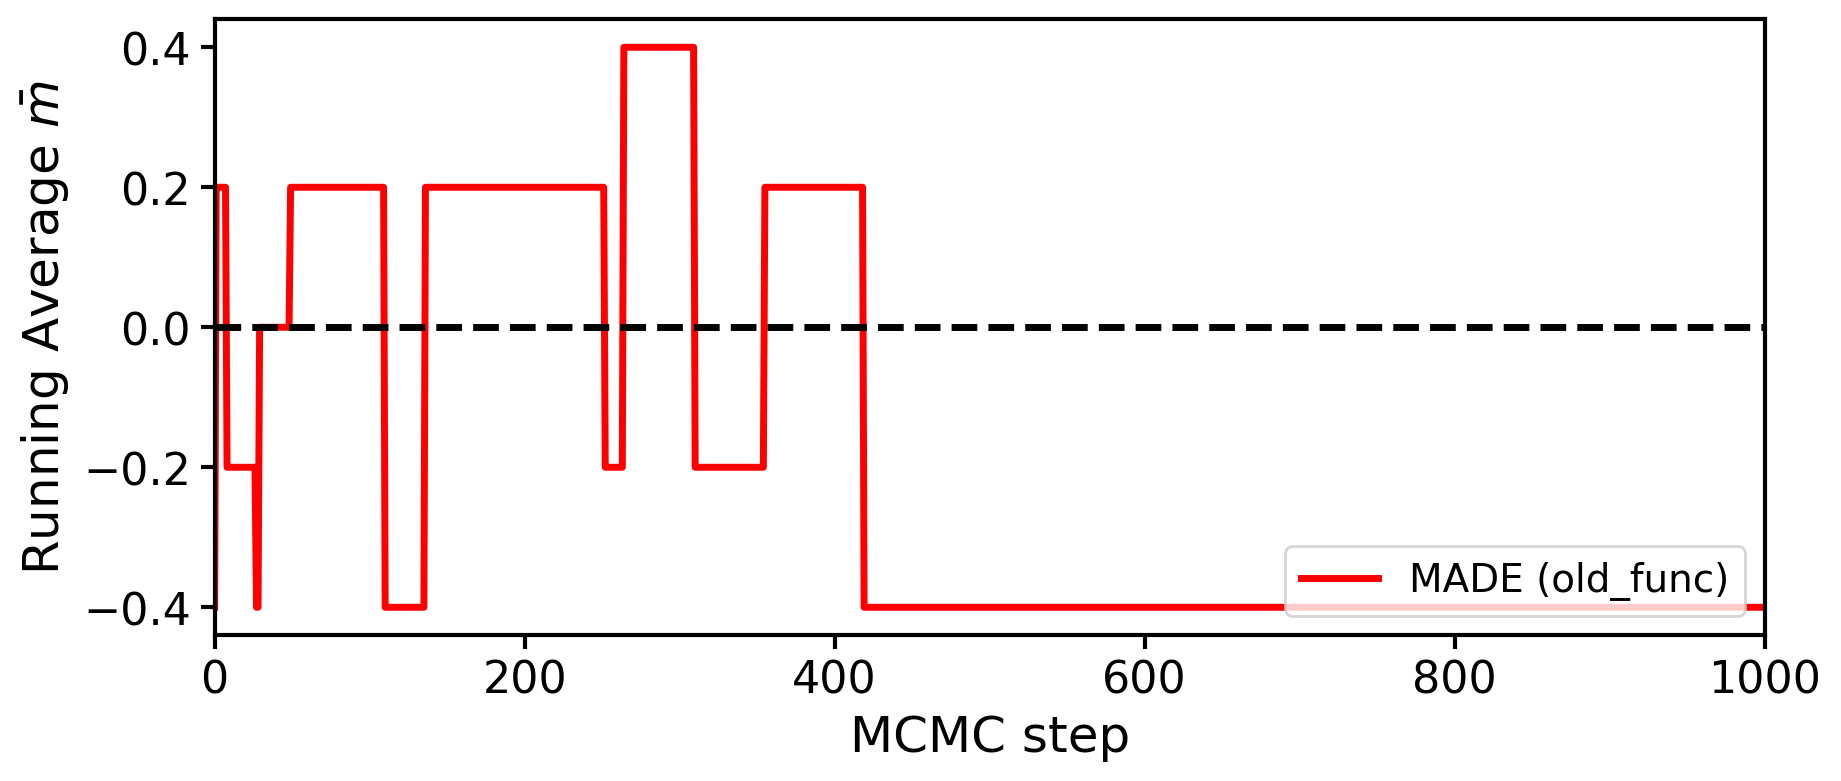

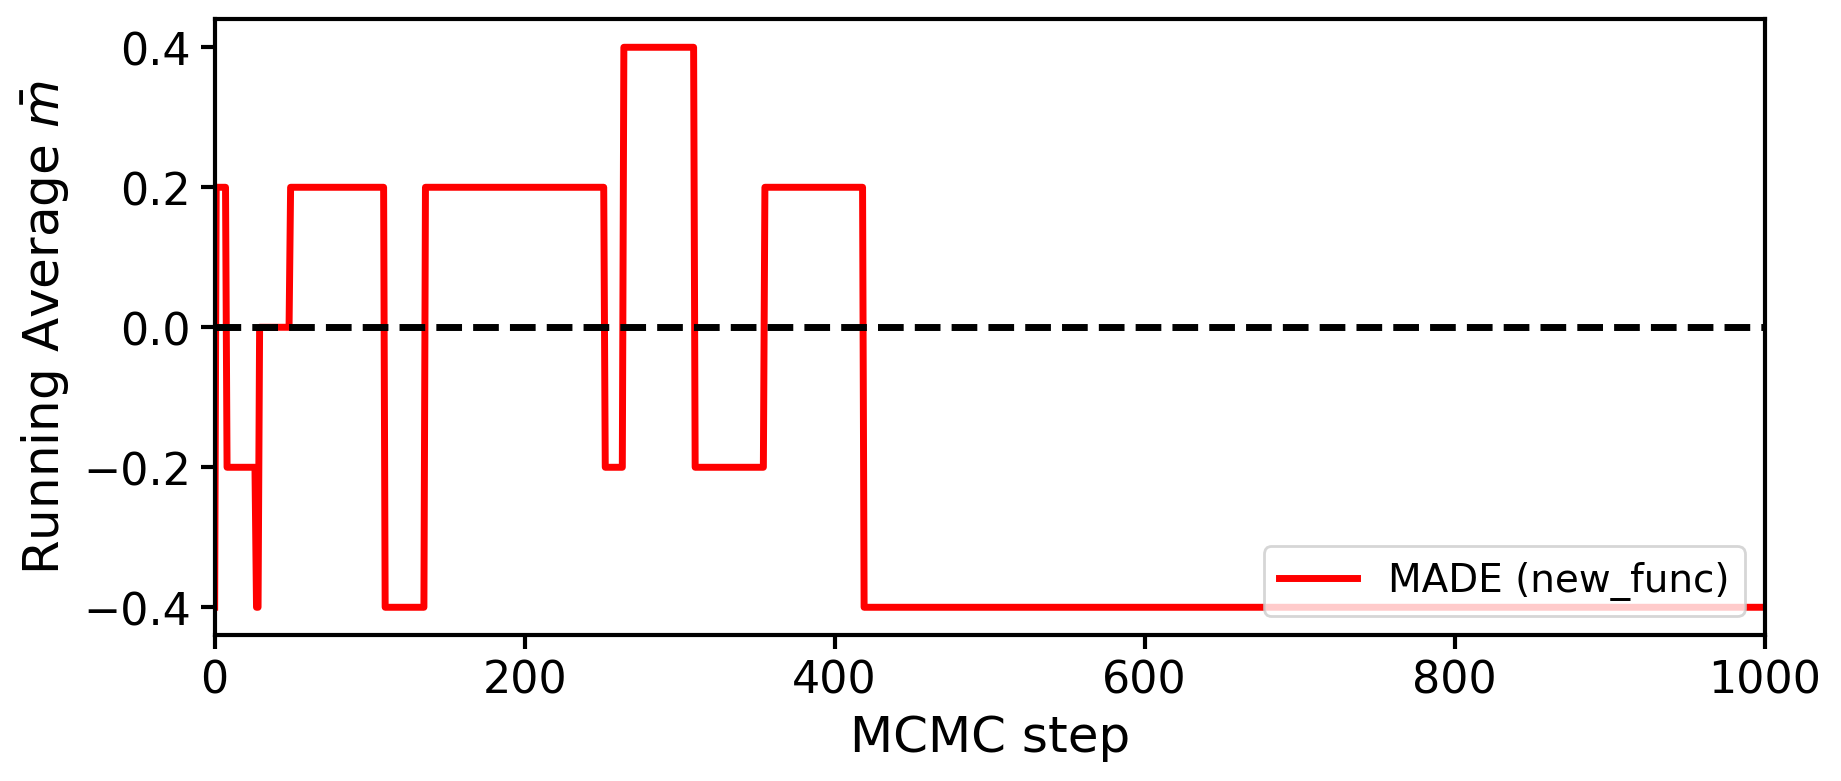

In [39]:
ssf_mag_made1 = np.average(state_history_made1, axis=1)
ssf_mag_made2 = np.average(state_history_made2, axis=1)
boltzmann_dist = ising.spin_boltzmann_distribution(instance, beta)
true_val = ising.boltzmann_average_magnetization(n_spin, boltzmann_dist)

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5

fig2_1, ax2_1 = plt.subplots(figsize=(10,4), dpi=200)

ax2_1.spines["top"].set_linewidth(spines)
ax2_1.spines["left"].set_linewidth(spines)
ax2_1.spines["bottom"].set_linewidth(spines)
ax2_1.spines["right"].set_linewidth(spines)

ax2_1.plot(np.arange(n_iter+1), ssf_mag_made1, color='red', linewidth=linewidth, label='MADE (old_func)')
ax2_1.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax2_1.set_xlim(0, n_iter)
#ax2_1.set_ylim(-0.3,0.3)
ax2_1.set_xlabel('MCMC step', fontsize=18)
ax2_1.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax2_1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2_1.tick_params(axis="x", which='major', width=1.5)
ax2_1.legend(fontsize=14, loc='lower right', frameon=True)

fig2_2, ax2_2 = plt.subplots(figsize=(10,4), dpi=200)

ax2_2.spines["top"].set_linewidth(spines)
ax2_2.spines["left"].set_linewidth(spines)
ax2_2.spines["bottom"].set_linewidth(spines)
ax2_2.spines["right"].set_linewidth(spines)

ax2_2.plot(np.arange(n_iter+1), ssf_mag_made2, color='red', linewidth=linewidth, label='MADE (new_func)')
ax2_2.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax2_2.set_xlim(0, n_iter)
#ax121.set_ylim(-0.3,0.3)
ax2_2.set_xlabel('MCMC step', fontsize=18)
ax2_2.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax2_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2_2.tick_params(axis="x", which='major', width=1.5)
ax2_2.legend(fontsize=14, loc='lower right', frameon=True)

#### 磁化平均

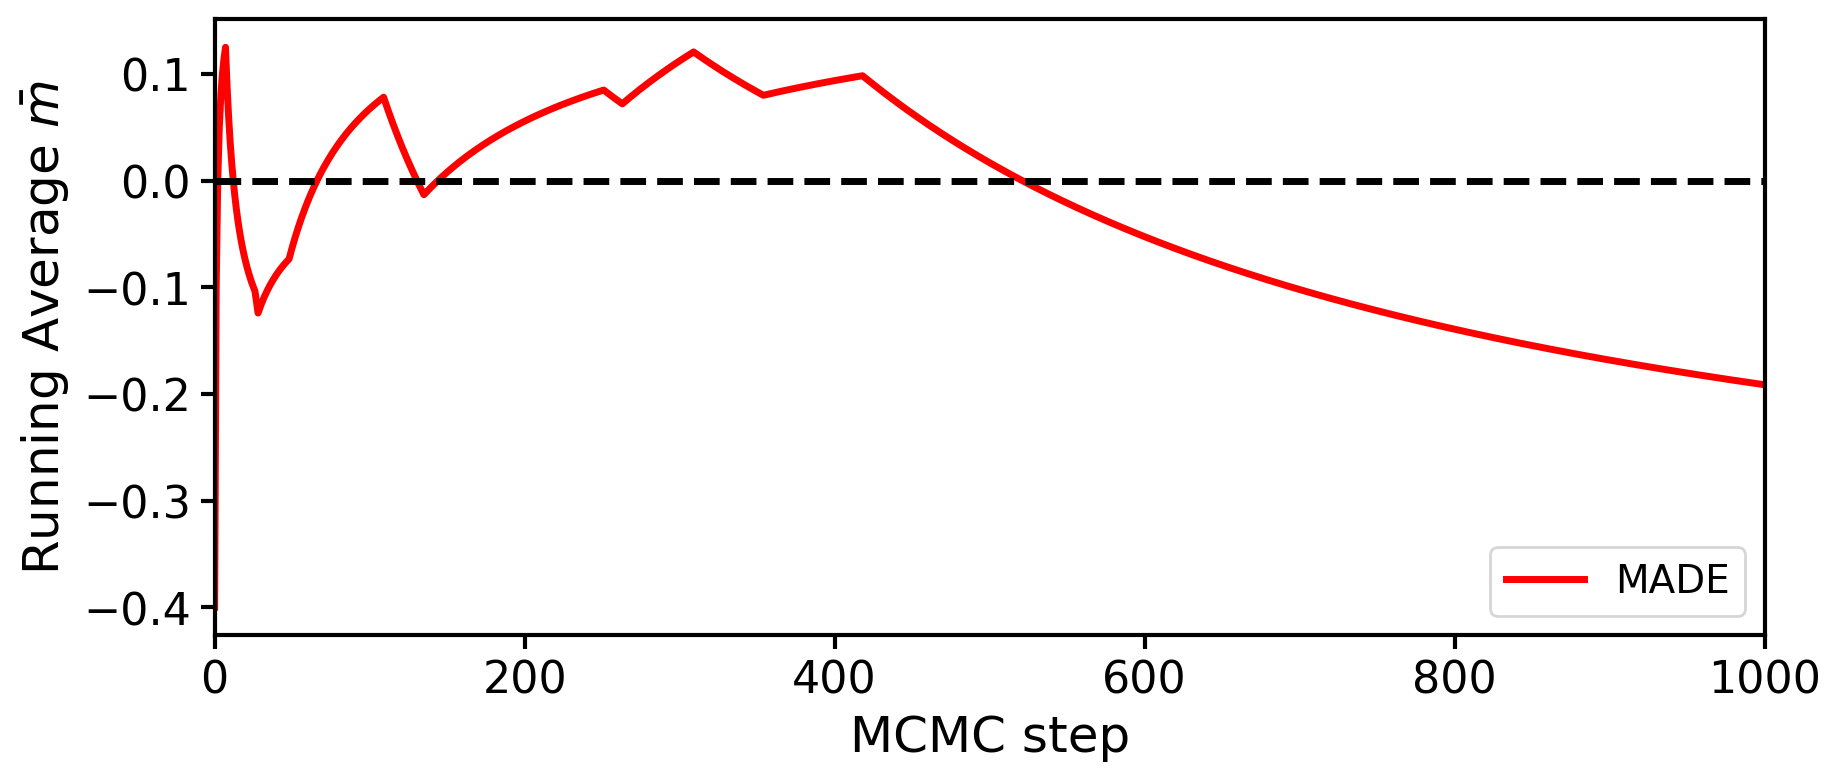

In [44]:
temp = np.arange(1, n_iter+2)
ave_mag_made2 = np.cumsum(ssf_mag_made2) / temp

fig2_3, ax2_3 = plt.subplots(figsize=(10,4), dpi=200)

ax2_3.spines["top"].set_linewidth(spines)
ax2_3.spines["left"].set_linewidth(spines)
ax2_3.spines["bottom"].set_linewidth(spines)
ax2_3.spines["right"].set_linewidth(spines)

ax2_3.plot(np.arange(n_iter+1), ave_mag_made2, color='red', linewidth=linewidth, label='MADE')
ax2_3.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax2_3.set_xlim(0, n_iter)
#ax131.set_ylim(-0.3,0.3)
ax2_3.set_xlabel('MCMC step', fontsize=18)
ax2_3.set_ylabel(r'Running Average $\bar{m}$', fontsize=18)
ax2_3.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2_3.tick_params(axis="x", which='major', width=1.5)
ax2_3.legend(fontsize=14, loc='lower right', frameon=True)

#### MADE提案分布の詳細

In [49]:
inputs = np.array([made.number_to_binary(i, n_spin) for i in range(2**n_spin)])
made_dist = made.compute_log_prob(model_qaoa_opt, inputs)
made_dist = np.exp(made_dist)

print(np.sort(made_dist))
print(np.sum(made_dist))

[7.77963205e-09 1.23928725e-08 2.47460772e-08 ... 1.25969335e-01
 1.72617927e-01 1.77702457e-01]
1.0
